**Table of contents**<a id='toc0_'></a>    
- [On-Policy Prediction with Approximation](#toc1_)    
  - [Estimating Value Functions with Supervised Learning](#toc1_1_)    
  - [The Objective for On-Policy Prediction](#toc1_2_)    
  - [The Objective for TD](#toc1_3_)    
  - [Linear TD](#toc1_4_)    
- [tldr](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[On-Policy Prediction with Approximation](#toc0_)

$\mathbf{OBJECTIVES}$

- Understand how we can use parameterized functions to approximate value functions
- Explain the meaning of linear value function approximation
- Recognize that the tabular case is a special case of linear value function approximation
- Understand that there are many ways to parameterize an approximate value function
- Understand what is meant by generalization and discrimination
- Understand how generalization can be beneficial
- Explain why we want both generalization and discrimination from our function approximation
- Understand how value estimation can be framed as a supervised learning problem
- Recognize not all function approximation methods are well suited for reinforcement learning
- Understand the mean-squared value error objective for policy evaluation
- Explain the role of the state distribution in the objective
- Understand the idea behind gradient descent and stochastic gradient descent
- Outline the gradient Monte Carlo algorithm for value estimation
- Understand how state aggregation can be used to approximate the value function
- Apply Gradient Monte-Carlo with state aggregation
- Understand the TD-update for function approximation
- Highlight the advantages of TD compared to Monte-Carlo
- Outline the Semi-gradient TD(0) algorithm for value estimation
- Understand that TD converges to a biased value estimate
- Understand that TD converges much faster than Gradient Monte Carlo
- Derive the TD-update with linear function approximation
- Understand that tabular TD(0) is a special case of linear semi-gradient TD(0)
- Highlight the advantages of linear value function approximation over nonlinear
- Understand the fixed point of linear TD learning
- Describe a theoretical guarantee on the mean squared value error at the TD fixed point

<p align="center">
  <img width="1000" height="400" src="imgs/rl-overview.png">
</p>

This week 

<p align="center">
  <img width="800" height="400" src="imgs/rl-overview-m2.png">
</p>

## <a id='toc1_1_'></a>[Estimating Value Functions with Supervised Learning](#toc0_)

We can formulate the function to approximation - $\textbf{Linear Value Function Approximation}$: 
$$
    \hat{v}(s, \mathbf{w}) = \sum w_i x_i(s)
$$

$\textbf{Framing Policy Evaluation as Supervised Learning:}$

For **Monte-Carlo** we can formulate the dataset as:
$$
\begin{align*}
    { (S_1, G_1), \\
      (S_2, G_2), \\
      (S_3, G_3), \\
      \dots
    }
\end{align*}
$$

where the inputs are the States $S$ and the targets are the returns $G$.

For **TD** we can formulate the dataset as:
$$
\begin{align*}
    { (S_1, R_2 + \gamma \hat{v}(S_2, w)), \\
      (S_2, R_3 + \gamma \hat{v}(S_3, w)), \\
      (S_3, R_4 + \gamma \hat{v}(S_4, w)), \\
      \dots
    }
\end{align*}
$$

In general we can give
- The state $s$ as input $x$
- And predict the **value estimate** $\approx v_{\pi}(s)$ as the target $y$

One **objective** we would like to optimize (like MSE, RMSE in classical ML) in RL is for example the $\textbf{Mean Squared Value Error}$ objective:
$$
    \text{Mean Squared Value Error} = \sum_s \mu(s)[ v_{\pi}(s) - \hat{v}(s, \mathbf{w}) ]^2
$$

where 
- each state is weighted by $\mu$
- and $\mu(s)$ should tell us how much we care about each state 

We see that this is a weighted sum of the squared error over all states.

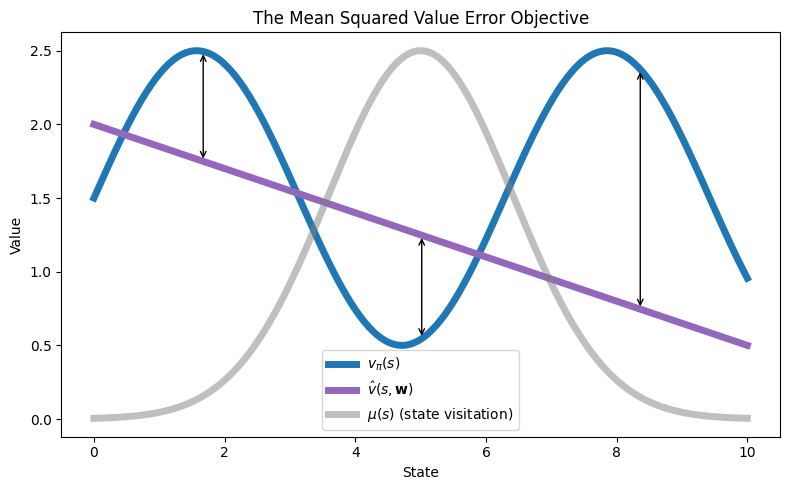

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Generate states
states = np.linspace(0, 10, 300)

# True value function V_pi(s) (nonlinear)
v_pi = np.sin(states) + 1.5

# Approximate value function V_hat(s, w) (linear approx)
v_hat = -0.15 * states + 2.0

# State-visitation frequency mu(s) as a distribution (more time spent in middle states)
mu_s = np.exp(-((states - 5)**2) / 4)
mu_s /= mu_s.max()  # Normalize for plotting (not to 1, just visually scaled)


# Plotting
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(states, v_pi, label=r"$v_\pi(s)$", color='C0', linewidth=5)
ax.plot(states, v_hat, label=r"$\hat{v}(s, \mathbf{w})$", color='C4', linewidth=5)
ax.plot(states, mu_s * 2.5, label=r"$\mu(s)$ (state visitation)", color='grey', alpha=0.5, linewidth=5)

# Add vertical error arrows at a few sample states
sample_indices = [50, 150, 250]
for idx in sample_indices:
    s = states[idx]
    y_true = v_pi[idx]
    y_hat = v_hat[idx]
    ax.annotate(
        '', xy=(s, y_true), xytext=(s, y_hat),
        arrowprops=dict(arrowstyle='<->', color='black')
    )

ax.set_xlabel("State")
ax.set_ylabel("Value")
ax.set_title("The Mean Squared Value Error Objective")

ax.legend()
plt.tight_layout()
plt.show()

- A natural measure for $\mu(s)$ is the fraction of time each state $S$ is visited under the policy $\pi$. 
  
That means we want to minimize the average value error for the states we visit while following Pi. The states that the policy spends more time in have a higher weight in the objective. We care less about errors in the states the policy visits less frequently. $\mu(s)$ is a probability distribution as shown on the slide. In this example, the policy spends little time at the extremes of the state space. 

## <a id='toc1_2_'></a>[The Objective for On-Policy Prediction](#toc0_)

<p align="center">
  <img width="600" height="300" src="imgs/gradient-descent.png">
</p>

- $\textbf{Gradient Descent}$ can be used to find stationary points of objectives
- These solutions are not always globally optimal

$\textit{How to use (stochastic) gradient descent to minimize value error?}$

<p align="center">
  <img width="500" height="300" src="imgs/gradient-of-the-msve-objective.png">
</p>

Even though realistically we don't have/know $\mu$ we can sample states from it simply by following the policy. We sample for example $(S_1, v_{\pi(S_1)})$ and use this pair to make an update to decrease the error on that example. We calculate the gradient for this single state and do gradient descent with this gradient to decrease the error on that state: 
$$
    \mathbf{w}_3 = \mathbf{w}_2 + \alpha[ v_{\pi}(S_2) - \hat{v}(S, \mathbf{w}_2) ] \nabla \hat{v}(S_2, \mathbf{w}_2)
$$
We perform this update to decrease the error for that specific pair. We den continue this process for other pairs. Again and again. This updating approach is called $\textbf{Stochastic Gradient Descent}$ (SGD).

We can think of SGD as a noisy approximation to the gradient that is much cheaper to compute, but can nonetheless make steady progress to a minimum. It is called *stochastic* because it only uses a stochastic estimate of the gradient. In fact, the expectation of each stochastic gradient equals the gradient of the objective.

> SGD allowed us to efficiently update the weights on every step by sampling the gradient

However, there is one issue: We DO NOT have access to $v_{\pi}$. We can estimate $v_{\pi}$ using Gradient Monte Carlo Algo.

$\textbf{Gradient Monte Carlo Algorithm}$ for value estimation

<p align="center">
  <img width="650" height="300" src="imgs/gradient-monte-carlo-algo.png">
</p>

It updates our current value estimate to be closer to a sample of the return $G_t$.


How else to approximate the values? 

$\textbf{State Aggregation}$: 

- Treats certain states as the same
- Is an example of linear function approximation
  - Thus, $\nabla \hat{v}(S_t, \mathbf{w}) = \mathbf{x}(S_t)$
- There is one feature of each group of aggregated states
- The approximate value of a state is the weight associated with the group that state belongs to.


## <a id='toc1_3_'></a>[The Objective for TD](#toc0_)

$\textbf{Semi-Gradient TD for Policy Evaluation}$:

- TD learning is built on the idea that the agent can use its own estimate of the value function to update its predictions.

<p align="center">
  <img width="600" height="300" src="imgs/td-is-semi-gradient.png">
</p>

<p align="center">
  <img width="650" height="300" src="imgs/semi-gradient-td-algo.png">
</p>

This algorithm does not have to wait until the end of an episode to make updates. TD performs an update on each step, unlike radio Monte Carlo.

$\textbf{Comparing TD and Monte Carlo with State Aggregation:}$

- TD converges to a biased value estimate
- TD can learn faster than Gradient Monte Carlo

<p align="center">
  <img width="600" height="300" src="imgs/td-converges-faster.png">
</p>

Gradient MC will converge to a local min of the MSVE - because it uses an unbiased estimate of the gradient of the value error. In theory, we need to run the algorithm for a very long time and decay the step size parameters to obtain this convergence. In practice, we use a constant step size. So the algorithm oscillates around a local minimum.

$$
    \mathbf{w} \leftarrow \mathbf{w} + \alpha [ \underbrace{{\color{red}{G_t}}}_{\text{Target}} - \hat{v}(S_t, \mathbf{w}) ] \nabla \hat{v}(S_t, \mathbf{w}) 
$$

Semi-Gradient TD will not necessarily converge to a local min of the MSVE. 

$$
    \mathbf{w} \leftarrow \mathbf{w} + \alpha [ \underbrace{{\color{red}{R_{t+1} + \gamma\hat{v}(S_{t+1}, \mathbf{w})}}}_{\text{Target}} - \hat{v}(S_t, \mathbf{w}) ] \nabla \hat{v}(S_t, \mathbf{w})
$$

- The TD update for function approximation can be **biased**
- We often prefer TD learning over MC anyway because it can converge more quickly

## <a id='toc1_4_'></a>[Linear TD](#toc0_)

$\textbf{TD Update with Linear Function Approximation.}$ In the linear case we get: 

$$
\begin{align*}
    \mathbf{w} &\leftarrow \mathbf{w} + \alpha\delta_t {\color{red}{\nabla \hat{v}(S_t, \mathbf{w})}} \qquad \quad {\color{grey}{\delta_t = R_{t+1} + \gamma\hat{v}(S_{t+1}, \mathbf{w}) - \hat{v}(S_t, \mathbf{w})}} \\ 
    \mathbf{w} &\leftarrow \mathbf{w} + \alpha\delta_t {\color{red}{x(S_t)}} 
    \\ \\
    \hat{v}(S_t, \mathbf{w}) &= \mathbf{w}^T\mathbf{x}(S_t) \\ 
    \nabla\hat{v}(S_t, \mathbf{w}) &= \mathbf{x}(S_t)
\end{align*}    
$$

Tabular $\texttt{TD(0)}$ is a special case of $\texttt{Linear Semi-Gradient TD(0)}$.

<p align="center">
  <img width="600" height="300" src="imgs/td-is-special-case-of-linear-td.png">
</p>

$\textbf{The Utility of Linear Function Approximation:}$

- Linear methods are *simpler to understand and analze* mathematically
- With **good features**, linear methods can learn quickly and achieve good prediction accuracy

In fact, linear TD provably converges to a well understood approximation called the TD fixed point.

$\textbf{The Expected TD Update:}$

$$
\begin{align}
    \mathbf{w}_{t+1} &= \mathbf{w}_t + \alpha[ R_{t+1}  + \gamma\hat{v}(S_{t+1, \mathbf{w}_t}) - \hat{v}(S_t, \mathbf{w}_t)] \mathbf{x}(S_t) \qquad \quad \hat{v}(S,\mathbf{w})=\mathbf{w}^T\mathbf{x}(s)
    \\
                    &= \mathbf{w}_t + \alpha[ R_{t+1}  + \gamma\mathbf{w}_t^T\mathbf{x}_{t+1} - \mathbf{w}_t^T\mathbf{x}_t]\mathbf{x}_t
    \\
                    &=  \mathbf{w}_t + \alpha[ R_{t+1}\mathbf{x}_t - \mathbf{x}_t(\mathbf{x}_t - \gamma \mathbf{x}_{t+1})^T\mathbf{w}_t]
    \\
    \mathbb{E}[\Delta\mathbf{w}_t] &= \alpha(\mathbf{b} - \mathbf{A}\mathbf{w}_t)
    \\
    \mathbf{b} &= \mathbb{E}[R_{t+1}\mathbf{x}_t] \qquad \mathbf{A} = \mathbb{E}[\mathbf{x}_t(\mathbf{x}_t - \gamma\mathbf{x}_{t+1})^T]
\end{align}    
$$

The weights are said to converge, when this expected TD update **(4)** is 0. We call this point $\textbf{TD Fixed Point}$ and it's solution is $\mathbf{w}_{TD}$.
$$
\begin{align}
    \mathbb{E}[\Delta\mathbf{w}_{TD}] = \alpha(\mathbf{b} - \mathbf{A}\mathbf{w}_t) = 0 \\
    \Longrightarrow \mathbf{w}_{TD} = \mathbf{A}^{-1}\mathbf{b}
\end{align}    
$$
$\mathbf{w}_{TD}$ minimizes $(\mathbf{b} - \mathbf{A}\mathbf{w})^T(\mathbf{b} - \mathbf{A}\mathbf{w})$.

- $\texttt{TD}$ = a sample based method for solving the Bellman equation
- $\texttt{Linear TD}$ = approximates the solution to the Bellman equation, minimizing what is called the projected *Bellman error*. 

We can formulate the relationship between the $\texttt{TD Fixed Point}$ and the minimum of the $\texttt{Value Error}$ as
$$
    \overline{\text{VE}}(\mathbf{w}_{TD}) \leq \frac{1}{1 - \gamma}\min_{\mathbf{w}} \overline{\text{VE}}(\mathbf{w})
$$

So in general, why isn't the TD fixed point equal to the minimum value error solution? This is because of bootstrapping under function approximation. If our estimate of the next state is persistently inaccurate due to function approximation, then TD forever update towards an inaccurate target. On the other hand, if our function approximator is very good, then our estimate of the next state will become very accurate. So bootstrapping off this estimate is not problematic and the error for the TD Solution is close to the minimum value error.

# <a id='toc2_'></a>[tldr](#toc0_)

- $\textbf{Gradient Descent}$ is a strategy to minimize objectives
- $\textbf{Value Error}$ is an objective for policy evaluation
- $\textbf{Semi-Gradient TD}$ is approximate gradient descent in the mean squared value error

$\textbf{TD Update with Linear Function Approximation:}$

$$
    \mathbf{w}_{t+1} = \mathbf{w}_t + \alpha[ R_{t+1}  + \gamma\hat{v}(S_{t+1, \mathbf{w}_t}) - \hat{v}(S_t, \mathbf{w}_t)] \mathbf{x}(S_t) \qquad \quad \hat{v}(S,\mathbf{w})=\mathbf{w}^T\mathbf{x}(s)
$$

- We described a parameterized value function $\hat{v}(s, \mathbf{w})$ as a mapping from states to real numbers. 
- The output is controlled by a vector of real valued weights $\mathbf{w}$.

The objective is to $\textbf{optimize the} \; \overline{VE}$:

- $\textbf{Stochastic Gradient Descent}$ can be used to optimize the objective:
  $$
    \mathbf{w} \leftarrow \mathbf{w} - \alpha [ v_{\pi}(S_t) - \hat{v}(S_t, \mathbf{w}) ] \nabla \hat{v}(S_t, \mathbf{w}) 
  $$
- $\textbf{Gradient Monte Carlo}$ can be used to optimize the objective:
  $$
    \mathbf{w} \leftarrow \mathbf{w} - \alpha [ G_t - \hat{v}(S_t, \mathbf{w}) ] \nabla \hat{v}(S_t, \mathbf{w}) 
  $$  

One can also use $\textbf{Semi-Gradient TD(0)}$ as an approximation to gradient descent:
$$
\begin{align}
    \mathbf{w} \leftarrow \mathbf{w} + \alpha [ &{\color{red}{U_t}} - \hat{v}(S_t, \mathbf{w}) ] \nabla \hat{v}(S_t, \mathbf{w})  
    \\
    &{\color{red}{U_t}} = R_{t+1} + \gamma\hat{v}(S_{t+1}, \mathbf{w})
\end{align}
$$
- takes advantage of bootstrapping is thus much faster than MC